 ## Dataset info

 http://help.sentiment140.com/for-students/

 ```
 The data is a CSV with emoticons removed. Data file format has 6 fields:
 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
 1 - the id of the tweet (2087)
 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
 4 - the user that tweeted (robotickilldozr)
 5 - the text of the tweet (Lyx is cool)
 ```

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import operator
import functools
import numpy as np
from nltk.tokenize import word_tokenize
import csv

train_data = []
# with open('training.1600000.processed.noemoticon.csv') as csvfile:
with open('testdata.manual.2009.06.14.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        newrow = [int(row[0]), row[5]]
        train_data.append(newrow)


train_positive_list = list(map(lambda r: r[1], filter(lambda r: r[0] == 4, train_data)))
train_positive = '\n'.join(train_positive_list)
train_nonpositive_list = list(map(lambda r: r[1], filter(lambda r: not r[0] == 4, train_data)))
train_nonpositive = '\n'.join(train_nonpositive_list)

# print(train_data) # won't work in jupyter due to amount of data

test_data = []
with open('testdata.manual.2009.06.14.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        newrow = [int(row[0]), row[5]]
        test_data.append(newrow)

test_positive_list = list(
    map(lambda r: r[1], filter(lambda r: r[0] == 4, test_data)))
test_positive = '\n'.join(test_positive_list)
test_nonpositive_list = list(map(lambda r: r[1], filter(lambda r: not r[0] == 4, test_data)))
test_nonpositive = '\n'.join(test_nonpositive_list)

real_values = [1 if tweet[0] == 4 else 0 for tweet in test_data]  # for testing

# print(test_data)



In [61]:
class NaiveBayes:

    def __init__(self, training_sets, labels):
        self.labels = labels
        self.k = len(self.labels)
        words = [word_tokenize(text) for text in training_sets]
        word_count = sum(len(word) for word in words)
        print(word_count)
        self.likelihoods = [{word: (words[i].count(word) + 0.5) /
                             len(words[i]) + 0.5 for word in words[i]} for i in range(self.k)]
        self.priors = [len(words[i]) / word_count for i in range(self.k)]

    def predict(self, input_text):
        probs = self._probabilities(input_text)
        best_index = np.argmax(probs)
        return self.labels[best_index]

    def _probabilities(self, text):
        words = word_tokenize(text)
        probs = [self._probability_for_class(words, i) for i in range(self.k)]
        return probs

    def _probability_for_class(self, words, k):
        probs_for_words = map(
            lambda word: self.likelihoods[k][word] if word in self.likelihoods[k] else np.finfo(np.float32).eps, words)
        prob_for_text = functools.reduce(operator.mul, probs_for_words, 1)
        return prob_for_text



In [62]:
nb = NaiveBayes([train_positive, train_nonpositive], [1, 0])



8604


[[315   1]
 [  1 181]]



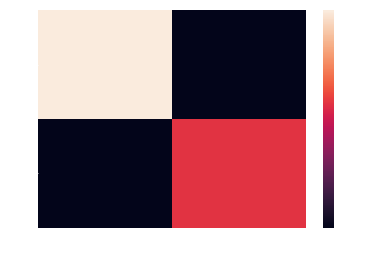

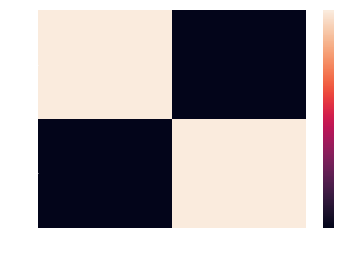

In [63]:

predictions = [nb.predict(tweet[1]) for tweet in test_data]
# print(predictions, real_values)

conf_mat = confusion_matrix(real_values, predictions)
print(conf_mat)

plt.figure()
sns.heatmap(conf_mat)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.figure()
conf_mat_normalized = conf_mat.astype(
    'float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

print()



In [64]:
my_accuracy = accuracy_score(real_values, predictions)
my_accuracy


0.9959839357429718

 ## Comparison

In [65]:
from scipy.sparse import csc_matrix

features_train = word_tokenize(train_positive + " " + train_nonpositive)
features_train = list(set(features_train))


In [66]:

# csc_matrix(shape = (len(train_positive_list) + len(train_nonpositive_list), len(words)))

x_train_row_zeros = [0] * len(features_train)
print(len(x_train_row_zeros))
x_train = [x_train_row_zeros[:] for _ in range(len(train_positive_list) + len(train_nonpositive_list))]

train_all_list = train_positive_list[:]
train_all_list.extend(train_nonpositive_list[:])

# print(train_all_list)

for x_i, tweet in enumerate(train_all_list):
    twords = word_tokenize(tweet)
    # print(twords)
    # print(x_i)
    utwords = list(set(twords))
    for word in utwords:
        try:
            count = twords.count(word) 
            idx = features_train.index(word)
            # print(word, count, idx)
            x_train[x_i][idx] = count
        except:
            pass
    # print(x_train[x_i])

# print(x_train[0])

y_train = [True] * len(train_positive_list)
y_train.extend([False] * len(train_nonpositive_list))

print(len(x_train))
print(len(y_train))
print(len(x_train[0]))
print(len(x_train[1]))
print(len(x_train[2]))


2699
498
498
2699
2699
2699


In [67]:


features_test = word_tokenize(test_positive + " " + test_nonpositive)
features_test = list(set(features_test))


In [68]:

# csc_matrix(shape = (len(train_positive_list) + len(train_nonpositive_list), len(words)))

x_test_row_zeros = [0] * len(features_test)
print(len(x_test_row_zeros))
x_test = []
x_test = [x_test_row_zeros[:] for _ in range(len(test_positive_list) + len(test_nonpositive_list))]

test_all_list = test_positive_list[:]
test_all_list.extend(test_nonpositive_list[:])

# print(test_all_list)

for x_i, tweet in enumerate(test_all_list):
    twords = word_tokenize(tweet)
    utwords = list(set(twords))
    for word in utwords:
        try:
            count = twords.count(word) 
            idx = features_test.index(word)
            x_test[x_i][idx] = count
        except:
            pass

y_test = []
y_test = [True] * len(test_positive_list)
y_test.extend([False] * len(test_nonpositive_list))


2699


In [69]:
# count_vect = CountVectorizer(binary="true")
# X_train_counts = count_vect.fit_transform([train_positive, train_nonpositive])
# X_train_counts.shape



In [69]:
clf = MultinomialNB()
clf.fit(x_train, y_train)



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
# test = np.array([ np.array([word_tokenize(case).count(word) for word in word_tokenize(case)]) for case in test_positive_list])
predictions_from_sklearn = clf.predict(x_test)
predictions_from_sklearn



array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [71]:
conf_mat = confusion_matrix(y_test, predictions_from_sklearn)
print(conf_mat)


[[311   5]
 [  4 178]]


In [72]:

accuracy_score(y_test, predictions_from_sklearn)


0.9819277108433735